In [1]:
import numpy as np
from skimage import transform

import cyvlfeat
from keras.models import Model
from keras.applications import vgg19
from keras.applications.vgg16 import preprocess_input

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold

from coremdlr.utils.viz_utils import show_images
from coremdlr.utils.facies_utils import make_labeled_frames

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
DATA_DIR = '/home/administrator/Dropbox/core_data/facies/Columns/'
SAVE_DIR = '/home/administrator/Dropbox/core_data/saved_models/'

img = np.load(DATA_DIR+'CoreLab_FULL_image.npy') 
labels = np.load(DATA_DIR+'CoreLab_FULL_facies.npy')

In [4]:
img -= img.min()
img /= img.max()
X, y = make_labeled_frames(img, labels, 96)
X.min(), X.max()

Making  6327  patches...
Label counts =  [(1, 418), (2, 322), (3, 285), (4, 2150), (5, 2057), (6, 250), (7, 664), (8, 90), (9, 91)]


(0.0, 1.0)

In [5]:
base_vgg = vgg19.VGG19(include_top=False)
vgg_feat = Model(inputs=base_vgg.input,
                  outputs=base_vgg.get_layer('block5_conv4').output)
vgg_feat.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

/home/administrator/anaconda3/envs/core-dev/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


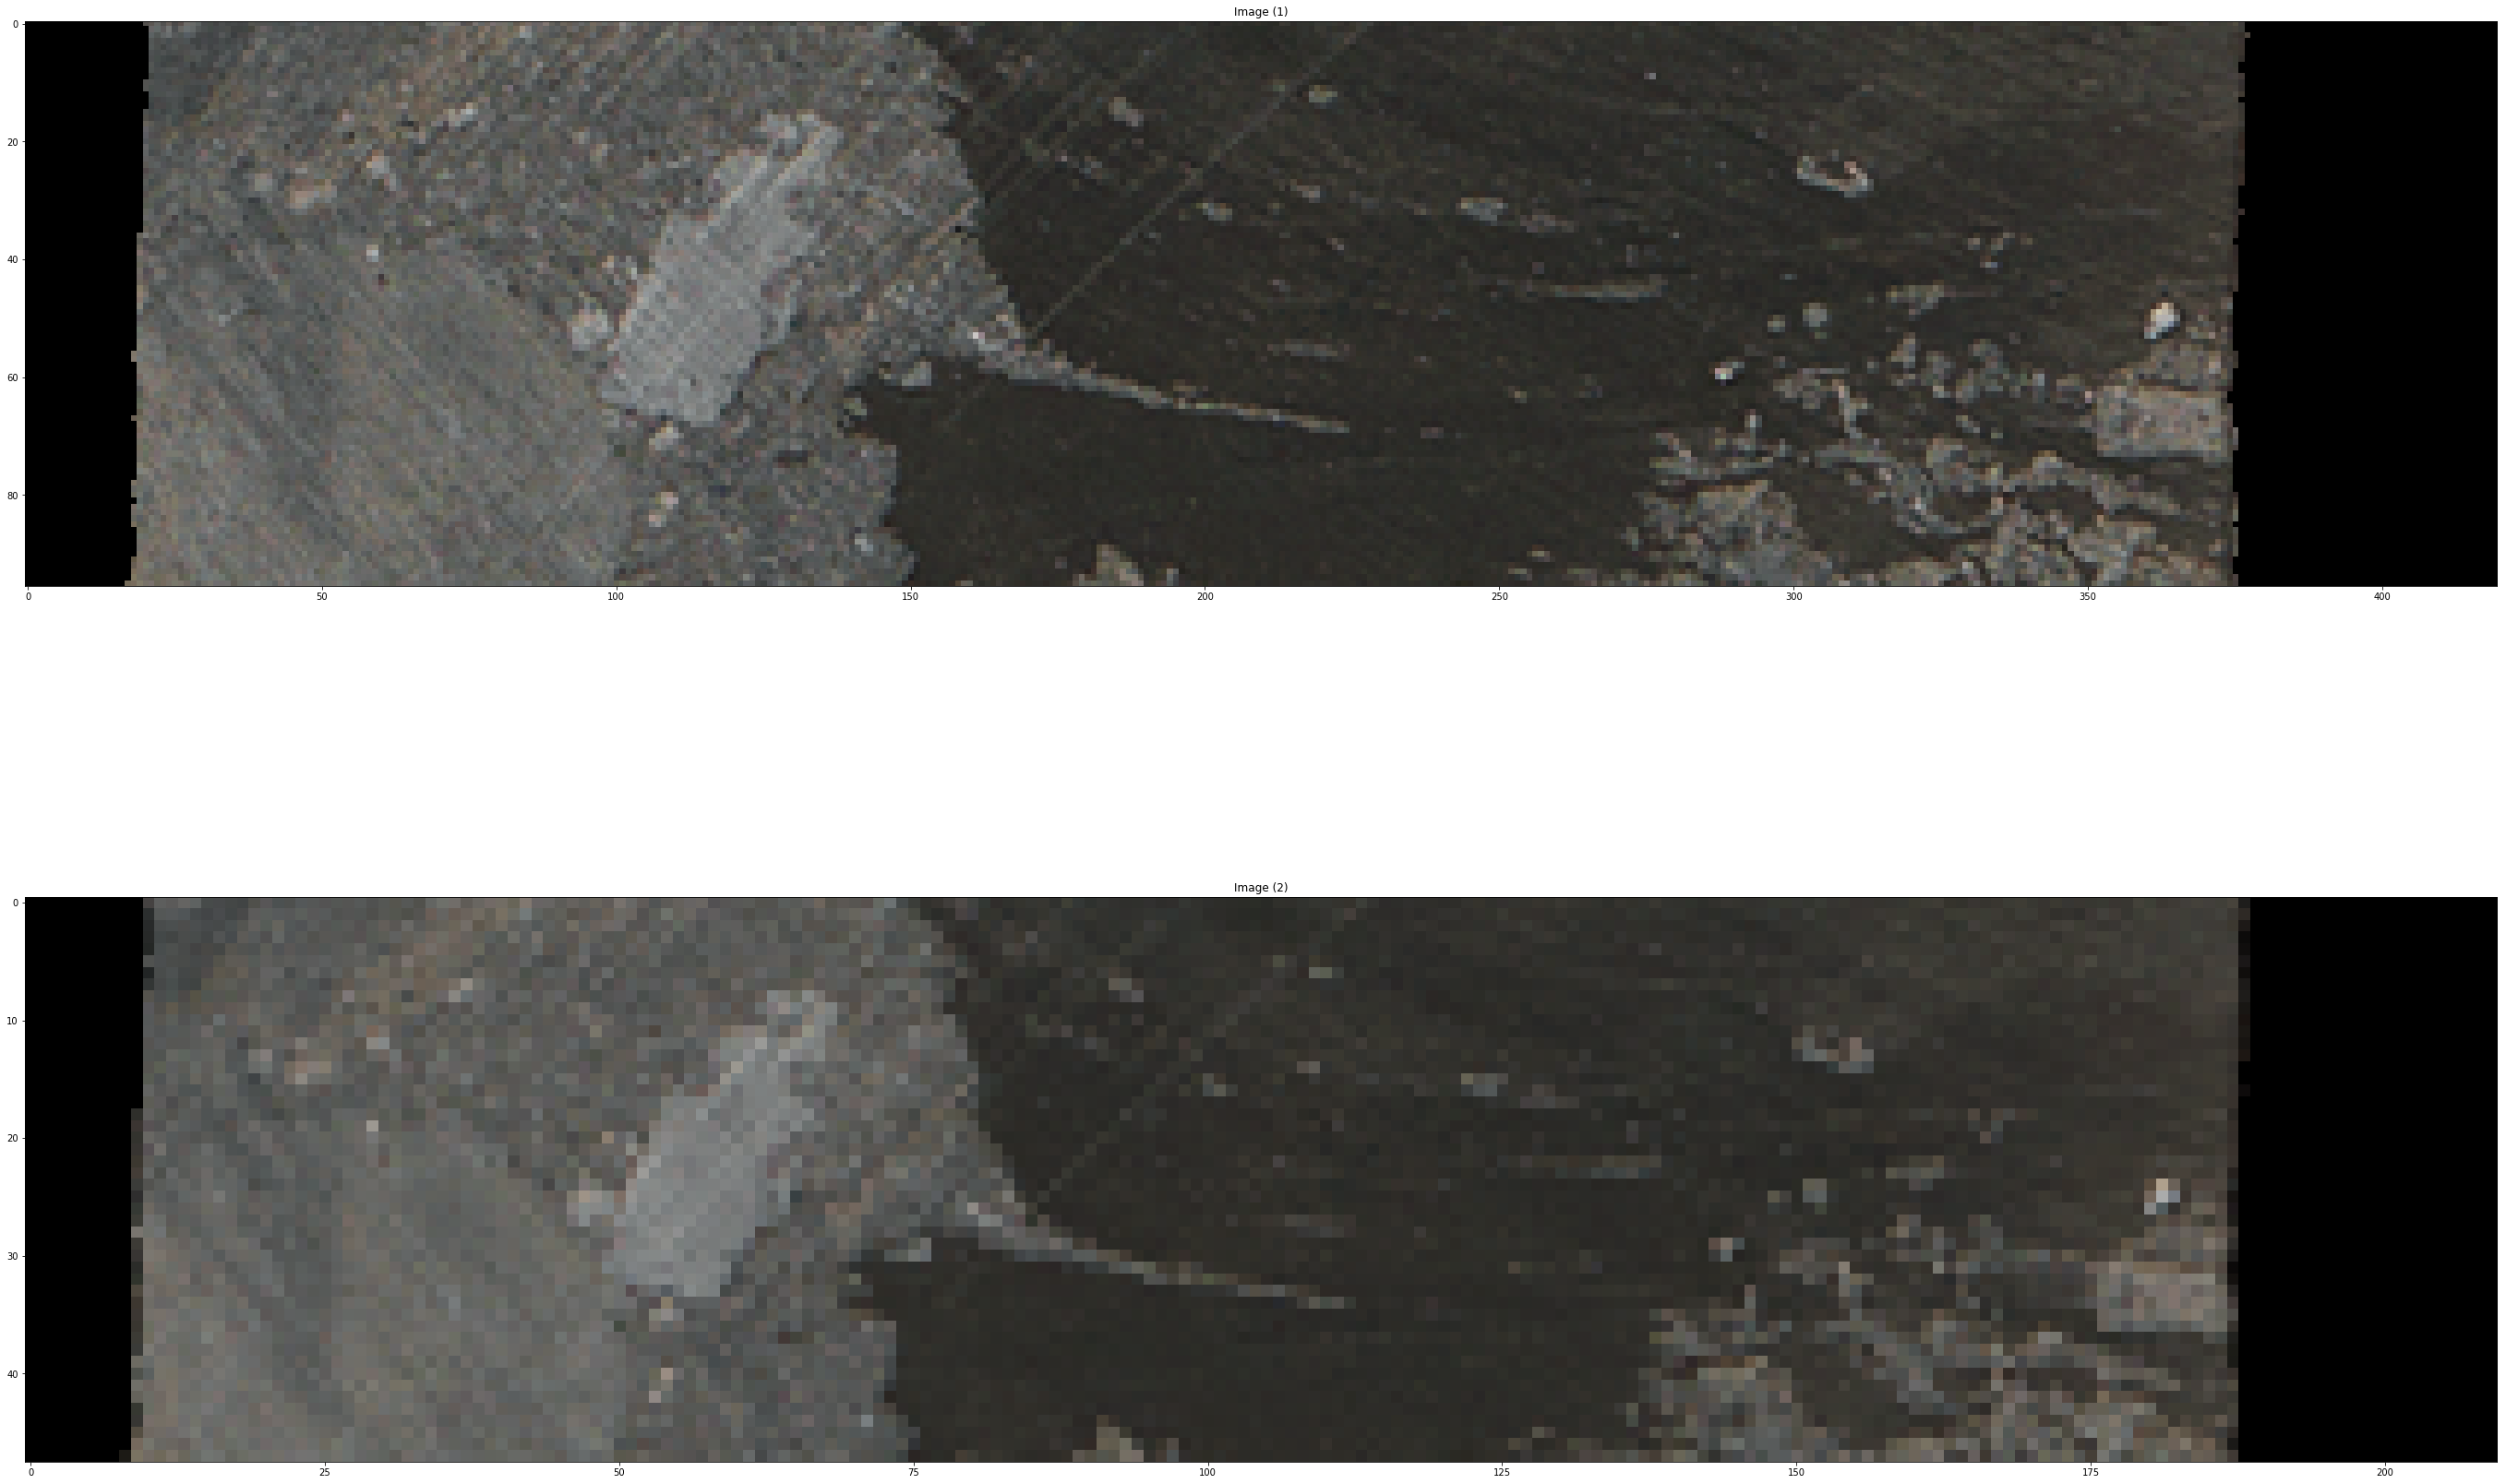

In [6]:
test_img = X[3]
test_img_rs = transform.resize(X[3], output_shape=(48,210), preserve_range=True)

show_images([test_img, test_img_rs], cols=2)

In [7]:
test_img = preprocess_input(np.expand_dims(test_img, axis=0))
test_img_rs = preprocess_input(np.expand_dims(test_img_rs, axis=0))

In [8]:
test_feats = vgg_feat.predict(test_img)
test_feats_rs = vgg_feat.predict(test_img_rs)
test_feats.shape, test_feats.size, test_feats_rs.shape, test_feats_rs.size

((1, 6, 26, 512), 79872, (1, 3, 13, 512), 19968)

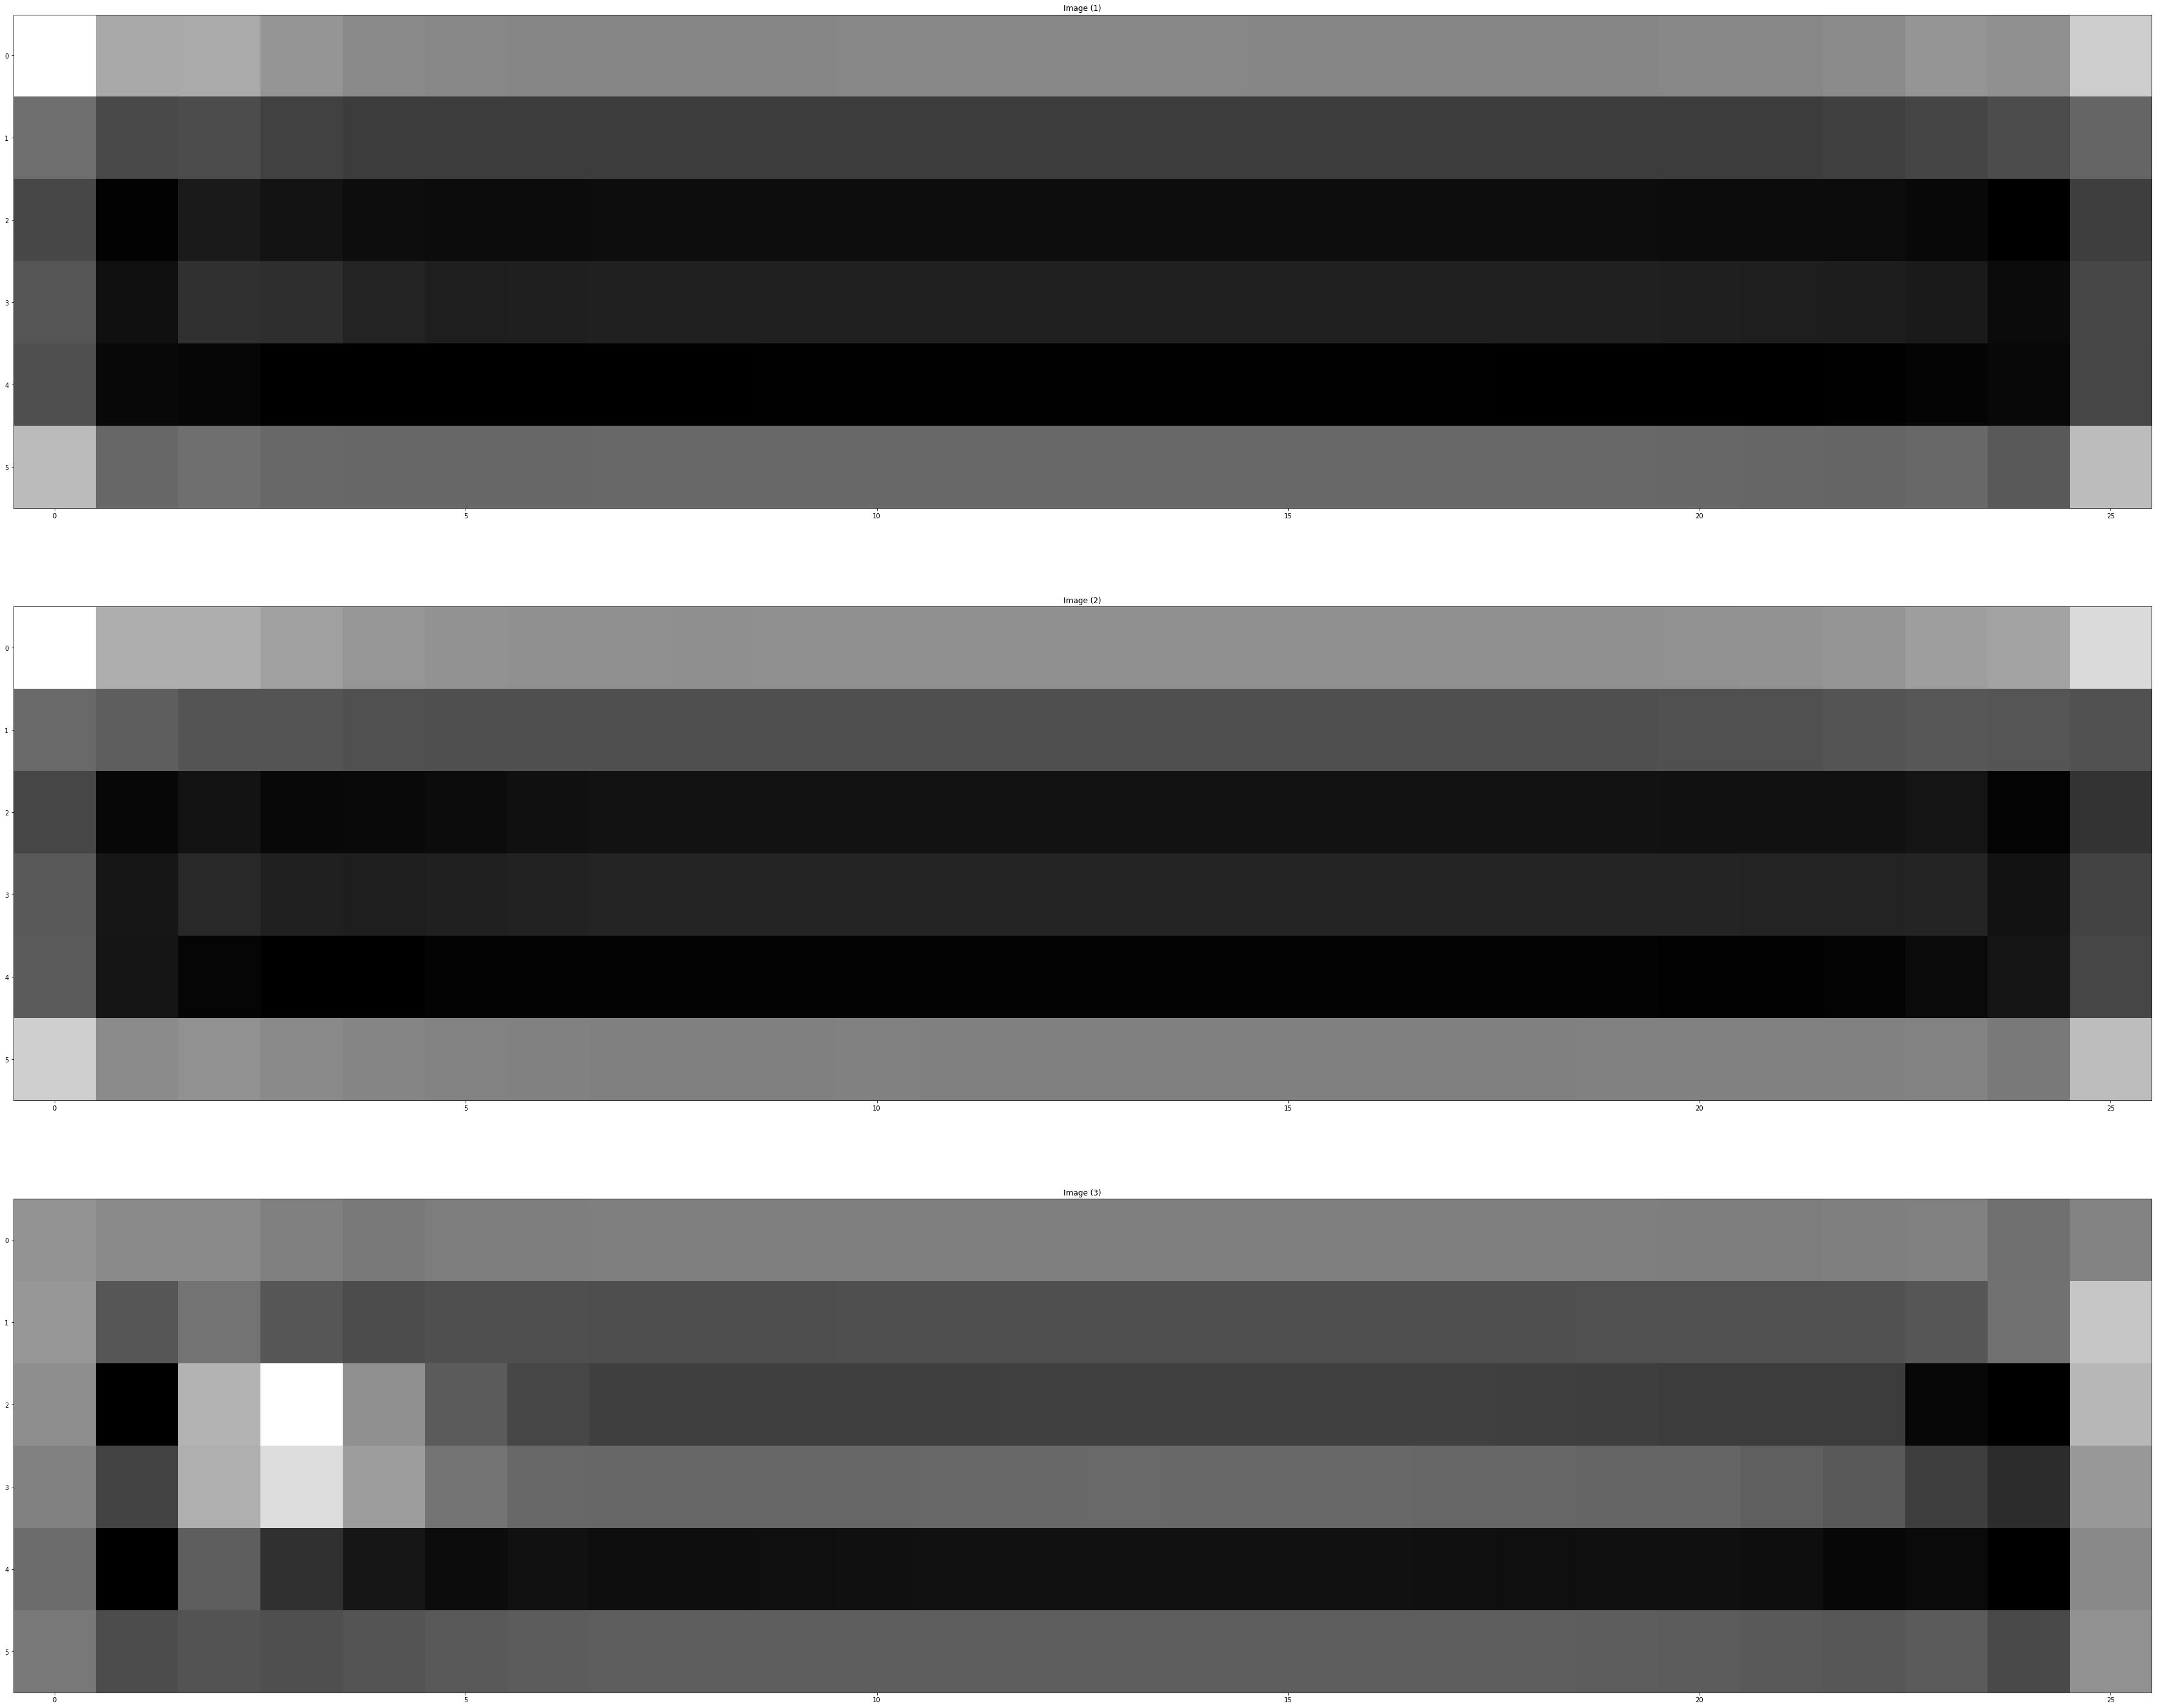

In [9]:
avg_feats = test_feats[0,...].mean(axis=-1)
max_feats = test_feats[0,...].max(axis=-1)
normed_feats = avg_feats / max_feats

show_images([avg_feats, max_feats, normed_feats], cols=3)

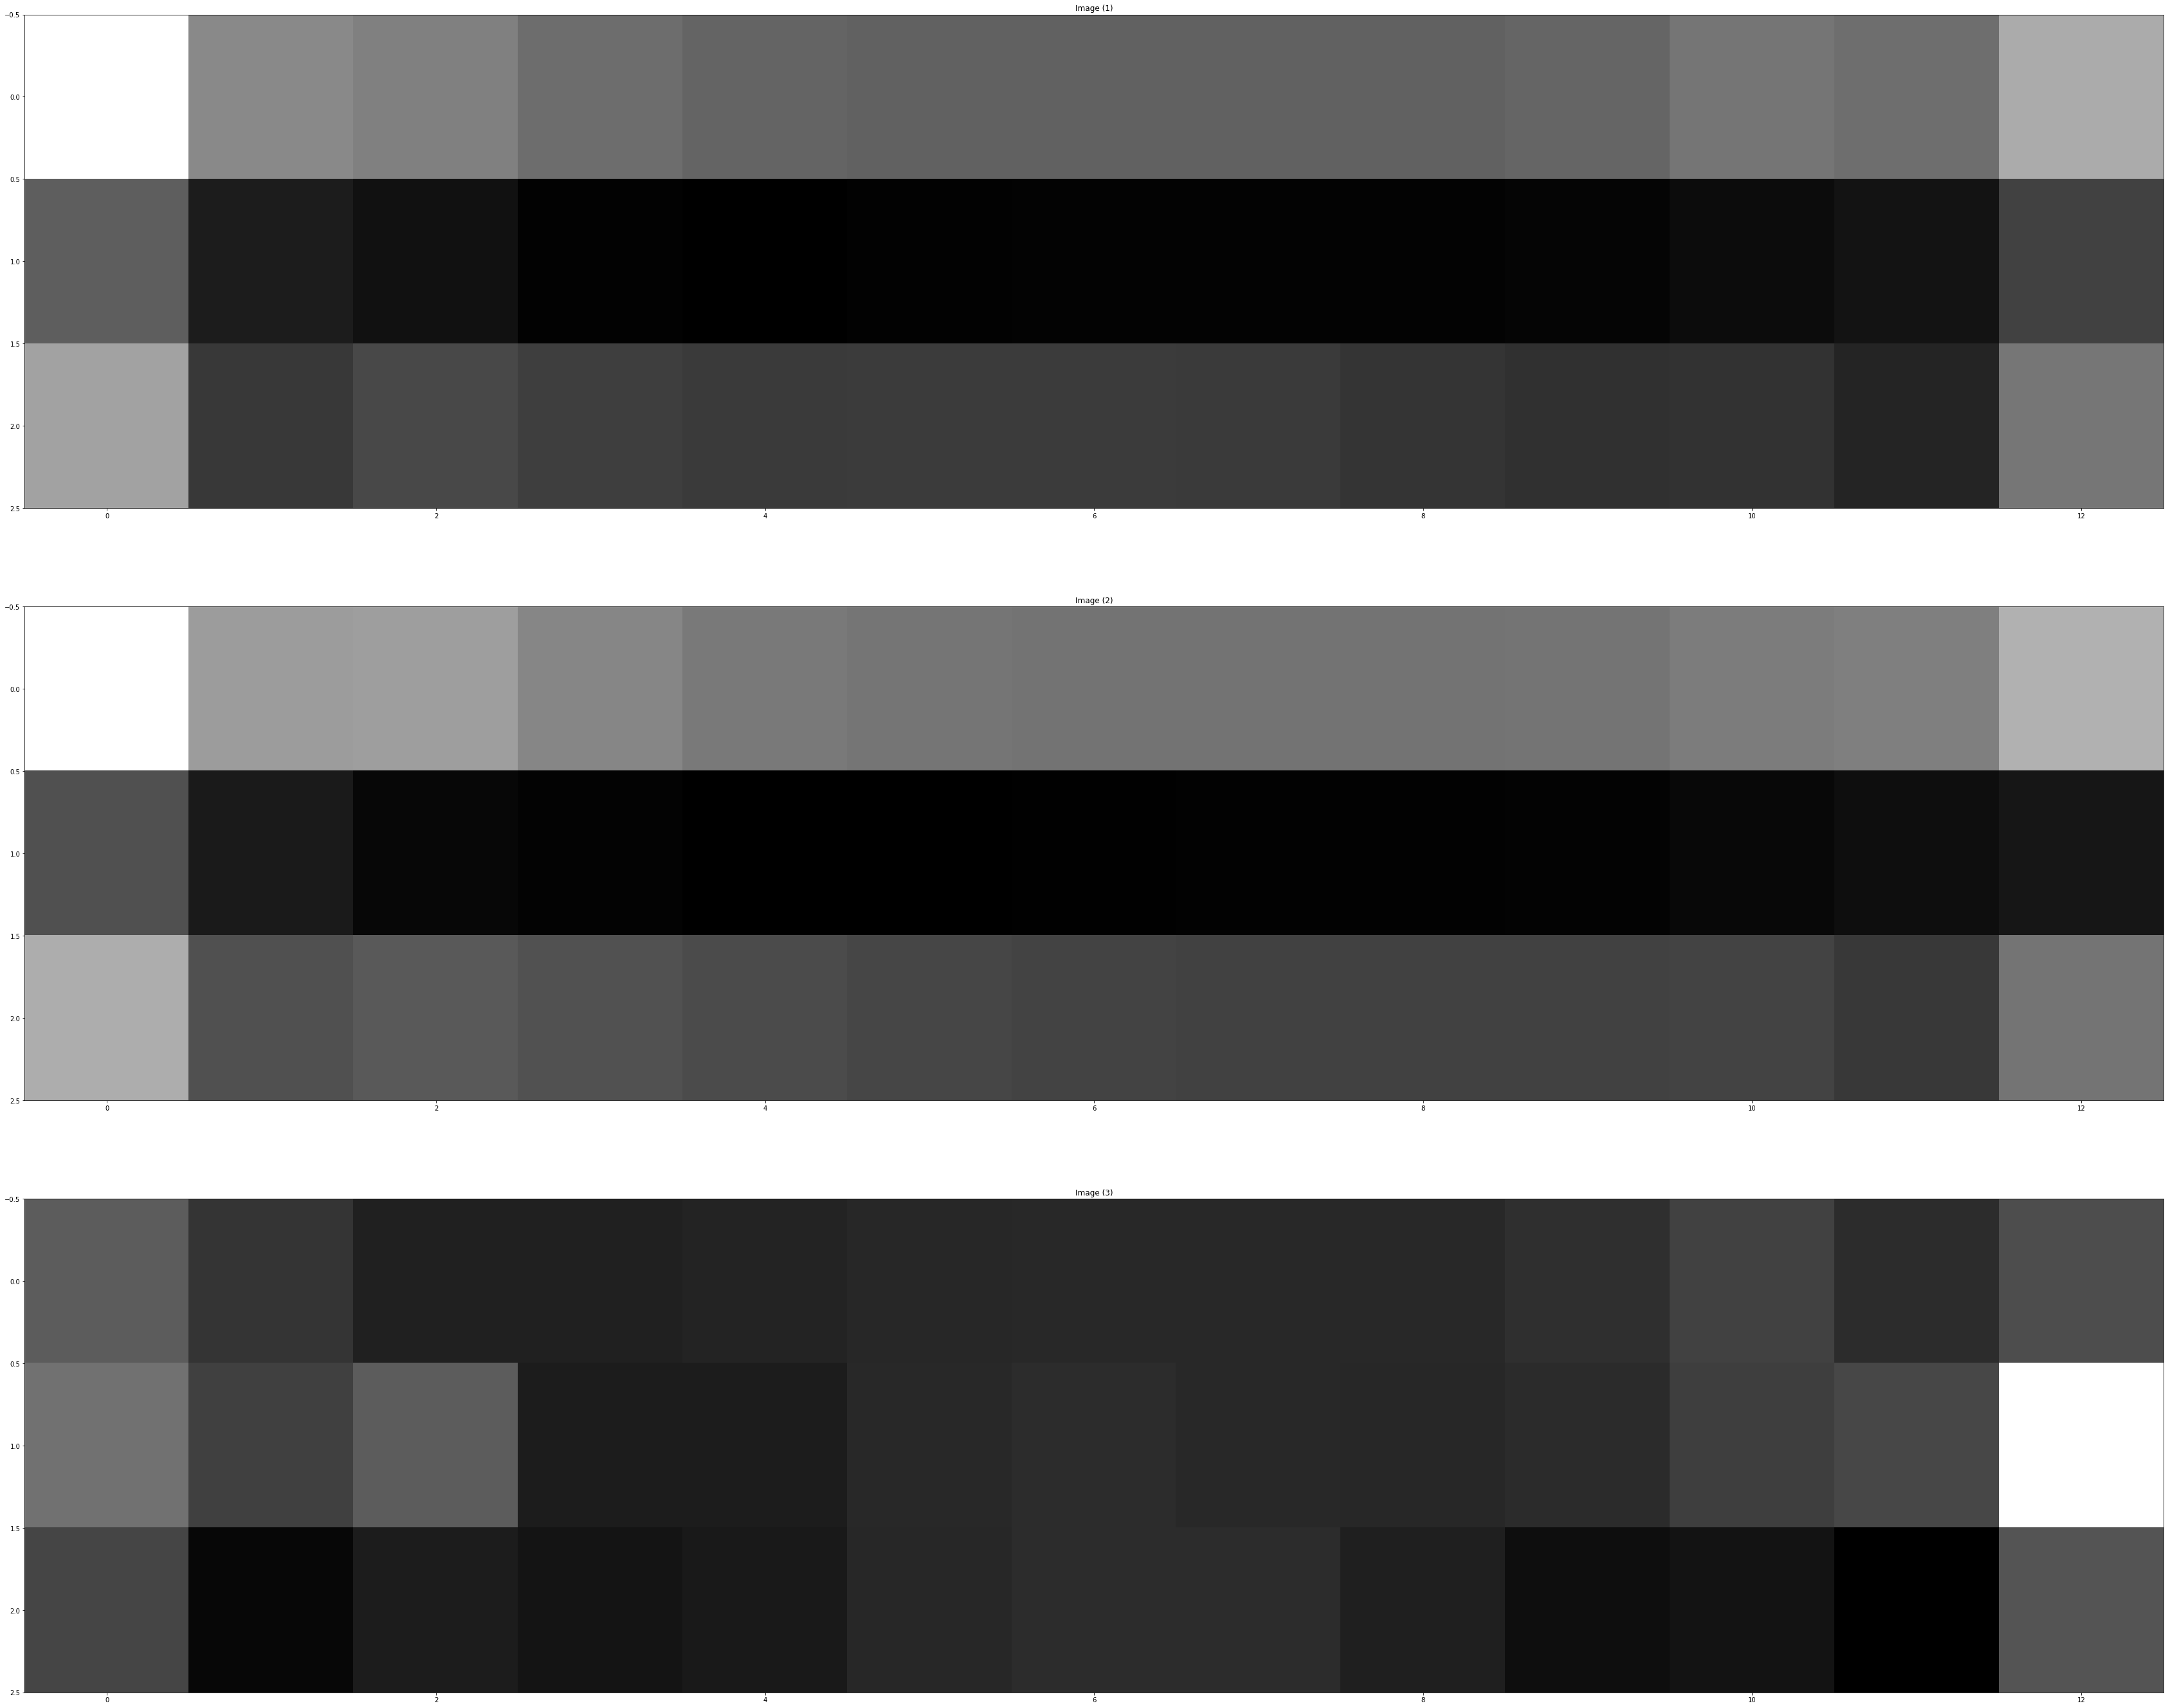

In [10]:
avg_feats_rs = test_feats_rs[0,...].mean(axis=-1)
max_feats_rs = test_feats_rs[0,...].max(axis=-1)
normed_feats_rs = avg_feats_rs / max_feats_rs

show_images([avg_feats_rs, max_feats_rs, normed_feats_rs], cols=3)

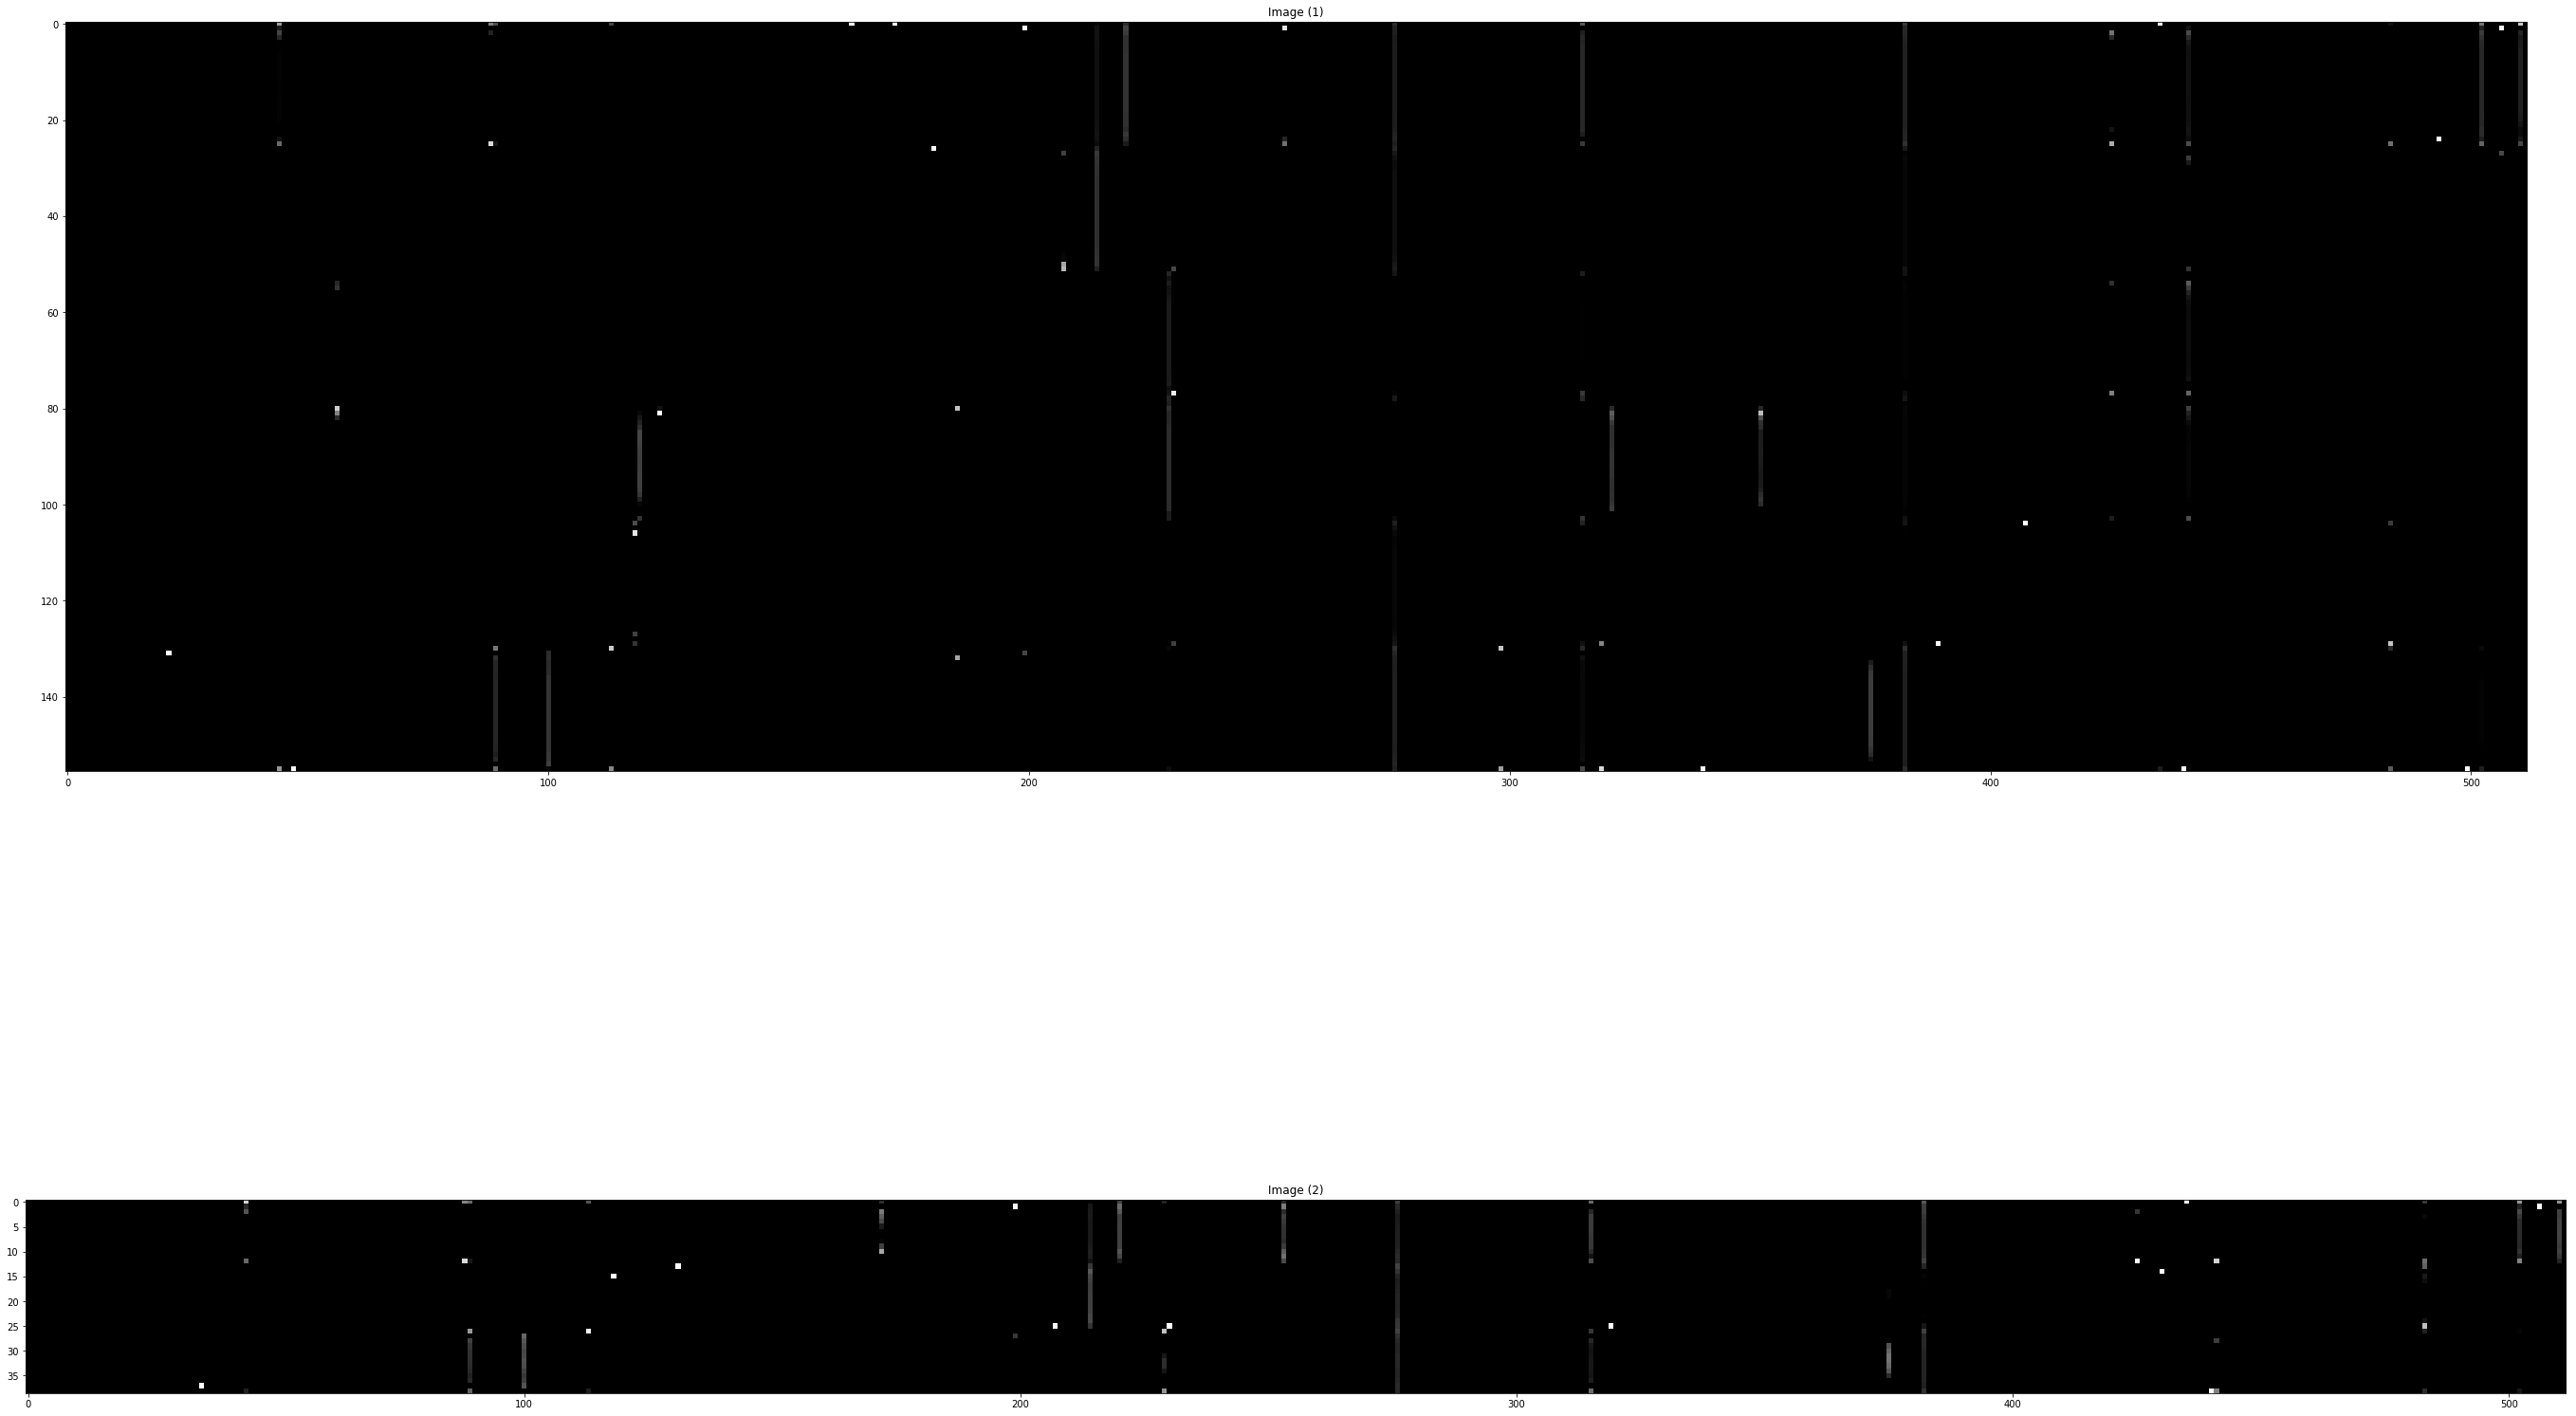

In [11]:
flat_tf = normalize(test_feats.reshape((6*26, 512)), axis=0)# , norm='max')
flat_tf_rs = normalize(test_feats_rs.reshape((3*13, 512)), axis=0) #, norm='max')

show_images([flat_tf, flat_tf_rs], cols=2)

## Make Features Array, Reduce Dims

In [12]:
# Need to remake frames because one sample already preprocessed
X, y = make_labeled_frames(img, labels, 96)

Making  6327  patches...
Label counts =  [(1, 418), (2, 322), (3, 285), (4, 2150), (5, 2057), (6, 250), (7, 664), (8, 90), (9, 91)]


In [14]:
X = preprocess_input(X)
X.shape

(6327, 96, 420, 3)

In [15]:
# Resample (simple every/other method)
X_rs = X[:, ::2, ::2, :]
X_rs.shape

(6327, 48, 210, 3)

In [16]:
X_feats = vgg_feat.predict(X)
X_feats_rs = vgg_feat.predict(X_rs)
X_feats.shape, X_feats_rs.shape

((6327, 6, 26, 512), (6327, 3, 13, 512))

In [19]:
def collapse_xy(batch):
    '''Collapse (n, x, y, c) array to (n, x*y, c)'''
    c = batch.shape[-1]
    return np.reshape(batch, batch.shape[:-3] + (-1, c))

In [20]:
local_Xf = collapse_xy(X_feats)
local_Xf_rs = collapse_xy(X_feats_rs)
local_Xf.shape, local_Xf_rs.shape

((6327, 156, 512), (6327, 39, 512))

In [31]:
feats = X_feats.reshape((-1, 512))
feats_rs = X_feats_rs.reshape((-1, 512))
feats.shape, feats_rs.shape

((987012, 512), (246753, 512))

### Fisher Vector Coding

In [45]:

means, covars, priors, LL, posteriors = cyvlfeat.gmm.gmm(feats, n_clusters=32)

In [82]:
x_enc = cyvlfeat.fisher.fisher(local_Xf[0,0].T[:,np.newaxis], means.T, covars.T, priors.T)
x_enc.shape

(32768,)

In [90]:
posteriors[posteriors.nonzero()].size / posteriors.shape[0]

2.0660640397482504

In [74]:
means.T.shape

(512, 32)

In [73]:
x0.shape

(512,)

In [75]:
64*28*28

50176

In [34]:
pca = PCA(n_components=512)
pca_rs = PCA(n_components=512)

In [35]:
pca.fit(feats)

PCA(copy=True, iterated_power='auto', n_components=512, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [36]:
pca_rs.fit(Xf_flat_rs)

PCA(copy=True, iterated_power='auto', n_components=512, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

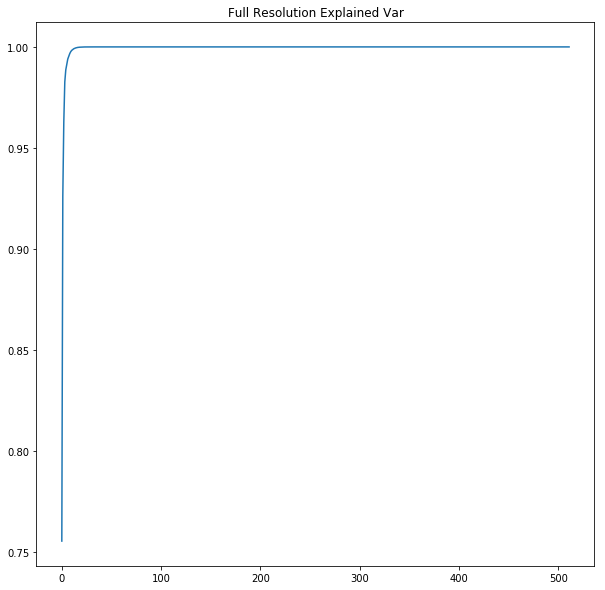

In [37]:
plt.figure(figsize=(10,10))
plt.title("Full Resolution Explained Var")
plt.plot(range(pca.n_components_), np.cumsum(pca.explained_variance_ratio_))

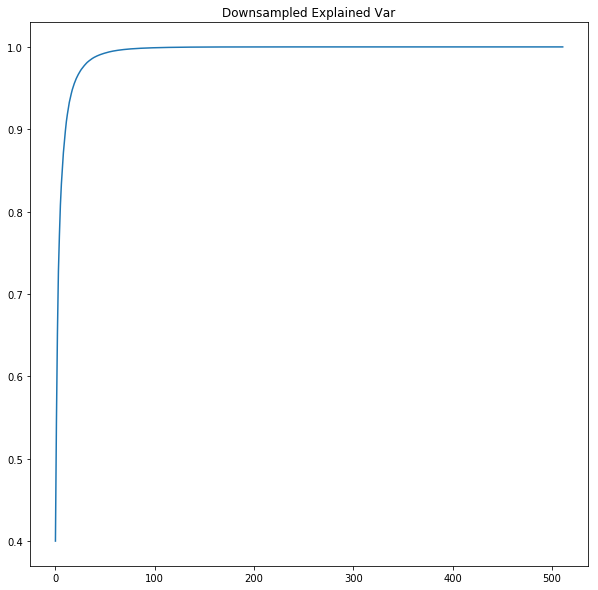

In [38]:
plt.figure(figsize=(10,10))
plt.title("Downsampled Explained Var")
plt.plot(range(pca_rs.n_components_), np.cumsum(pca_rs.explained_variance_ratio_))

7800

In [ ]:
#X_feats = {}; X_feats_rs = {}; y_fold = {};

#for k, (train_idx, test_idx) in enumerate(skf):
#    X_feats[k] = vgg_feat.predict(X[train_idx])